# Create reproducible and debuggable models using Lance

Lance is an open source library for blazing fast exploration and analysis of ML data using python and SQL, backed by an Apache-Arrow compatible data format

Basic imports

In [1]:
# !pip install --quiet pylance torch torchvision
import os

import numpy as np
import pandas as pd
import pyarrow as pa
import torch

import lance
print(lance.__version__)

0.2.8.dev0


DuckDB for SQL support

In [2]:
# pip install --quiet git+https://github.com/eto-ai/ipython-sql.git
# pip install --quiet duckdb duckdb-engine
import duckdb
import sql

%load_ext sql
%sql duckdb:///:memory: {}

{}


We'll use the oxford pets dataset

In [3]:
uri = "s3://eto-public/datasets/oxford_pet/oxford_pet.lance"
oxford_pet = lance.dataset(uri)

In [4]:
%%sql df << 

SELECT external_image as _image, class as _label, _pk, split
FROM oxford_pet

Took 1.5178945064544678


,_image,_label,_pk,split
0,https://eto-public.s3.us-west-2.amazonaws.com/...,Abyssinian,0,train
1,https://eto-public.s3.us-west-2.amazonaws.com/...,Abyssinian,1,train
2,https://eto-public.s3.us-west-2.amazonaws.com/...,Abyssinian,2,train
3,https://eto-public.s3.us-west-2.amazonaws.com/...,Abyssinian,3,train
4,https://eto-public.s3.us-west-2.amazonaws.com/...,Abyssinian,4,train
...,...,...,...,...
7344,https://eto-public.s3.us-west-2.amazonaws.com/...,yorkshire_terrier,7344,test
7345,https://eto-public.s3.us-west-2.amazonaws.com/...,yorkshire_terrier,7345,test
7346,https://eto-public.s3.us-west-2.amazonaws.com/...,yorkshire_terrier,7346,test
7347,https://eto-public.s3.us-west-2.amazonaws.com/...,yorkshire_terrier,7347,test


In [5]:
!rm -rf /home/ubuntu/datasets/demo.lance
uri = '/home/ubuntu/datasets/demo.lance'

schema = pa.schema([
    pa.field('_image', pa.string()),
    pa.field('_label', pa.string()),
    pa.field('_pk', pa.int64()),
    pa.field('split', pa.string())
])
tbl = pa.Table.from_pandas(df, schema=schema)

## Automatic zero-copy versioning

Lance automatically creates versions incrementally as you add rows and columns <br/>
WITHOUT needing to create duplicate snapshot copies <br/>
So you can save a lot of storage space and data management headaches

In [6]:
day1_data = tbl[:1000]
lance.write_dataset(day1_data, uri)

Assume new data arrives in batches between model iterations

In [7]:
for i in range(1, 8):
    start = 1000 * i
    end = 1000 * (i + 1)
    batch = tbl[start:end]
    lance.write_dataset(batch, uri, mode='append')

Each iteration is versioned automatically

In [8]:
train = lance.dataset(uri)
train.versions()

[{'version': 1,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 52, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 2,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 3,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 4,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 5,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 6,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 7,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 8,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}}]

## Easy data diff'ing
### Show training examples that were added in the new version

In [9]:
diff = lance.diff(train, 4, 8)
diff

LanceDiff
  Added: 3349 rows, 0 columns

In [10]:
(diff.rows_added("_pk")
 .head().to_pandas())

,_image,_label,_pk,split
0,https://eto-public.s3.us-west-2.amazonaws.com/...,english_setter,5000,test
1,https://eto-public.s3.us-west-2.amazonaws.com/...,english_setter,5001,test
2,https://eto-public.s3.us-west-2.amazonaws.com/...,english_setter,5002,test
3,https://eto-public.s3.us-west-2.amazonaws.com/...,english_setter,5003,test
4,https://eto-public.s3.us-west-2.amazonaws.com/...,english_setter,5004,test
5,https://eto-public.s3.us-west-2.amazonaws.com/...,english_setter,5005,test
6,https://eto-public.s3.us-west-2.amazonaws.com/...,english_setter,5006,test
7,https://eto-public.s3.us-west-2.amazonaws.com/...,english_setter,5007,test
8,https://eto-public.s3.us-west-2.amazonaws.com/...,english_setter,5008,test
9,https://eto-public.s3.us-west-2.amazonaws.com/...,english_setter,5009,test


## Compute metrics across versions

In [11]:
# Compute normalized label distribution
def value_count(ds):
    return duckdb.query(
        "SELECT _label, count(*) * 1.0 / (SELECT count(*) FROM ds) as value_count "
        "FROM ds GROUP BY 1"
    ).to_df()

In [12]:
metrics = lance.compute_metric(train, value_count, versions=[1, 4, 8])
metrics

,_label,value_count,version
0,Abyssinian,0.050000,1
1,american_bulldog,0.050000,1
2,american_pit_bull_terrier,0.050000,1
3,basset_hound,0.050000,1
4,beagle,0.050000,1
...,...,...,...
32,keeshond,0.027079,8
33,leonberger,0.027215,8
34,Maine_Coon,0.027215,8
35,miniature_pinscher,0.027215,8


<AxesSubplot: xlabel='_label'>

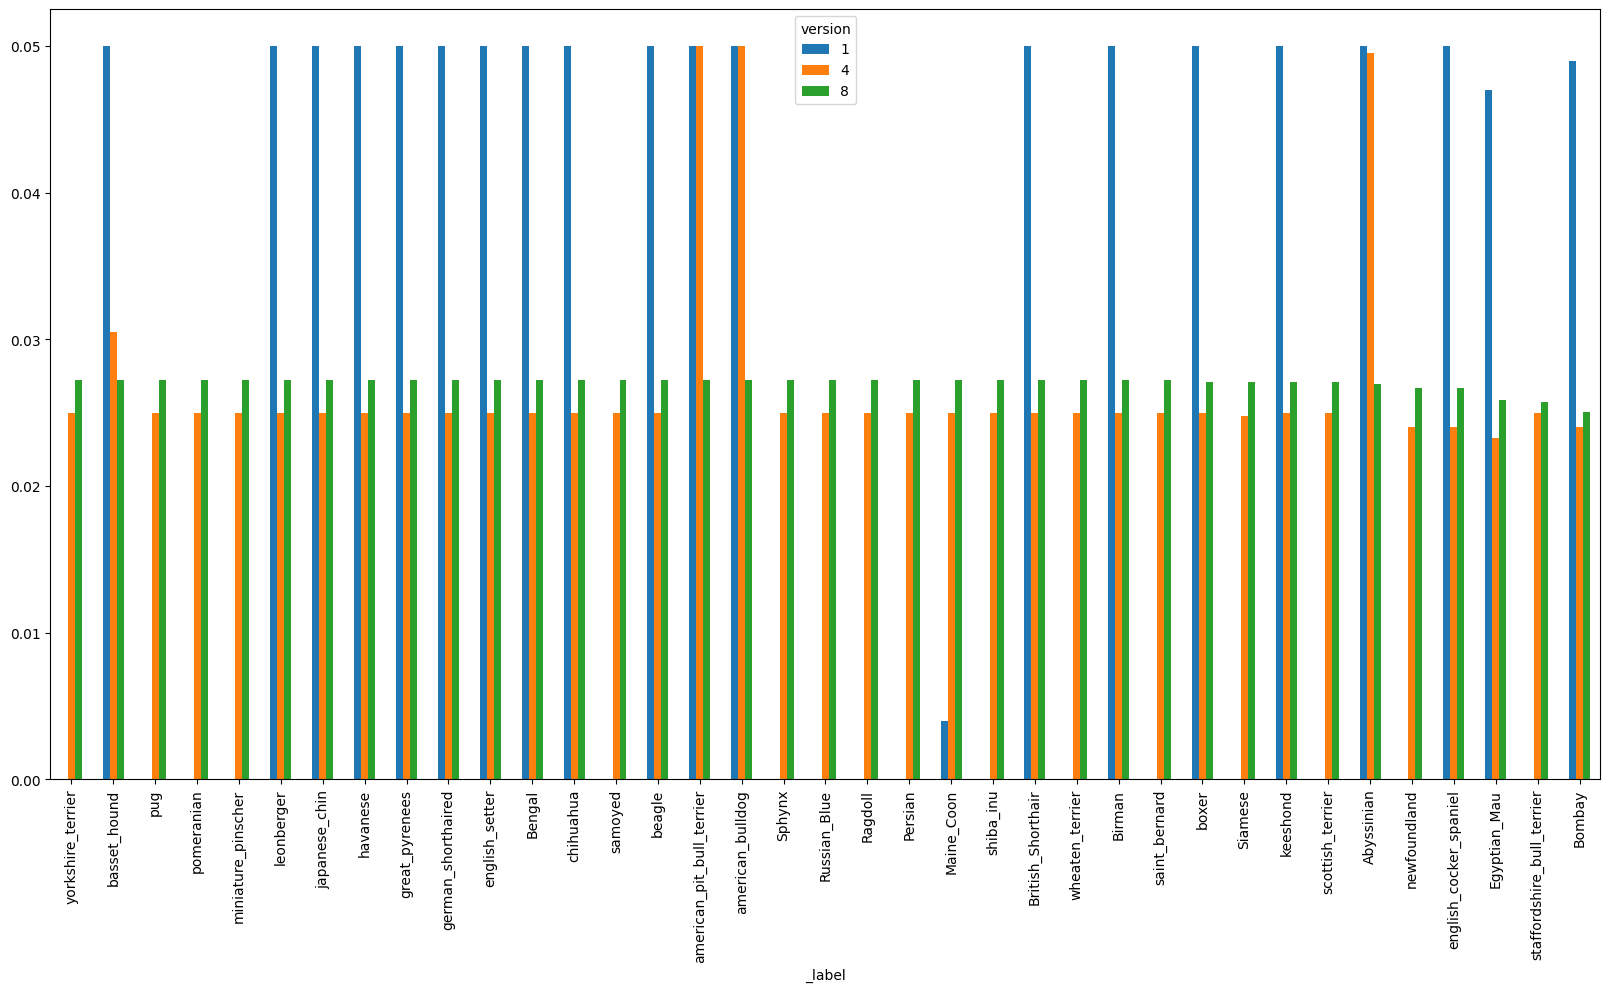

In [13]:
(metrics
 .pivot(index='_label', columns='version', values='value_count')
 .sort_values(8, ascending=False)
 .plot.bar(figsize=(20,10)))

In the data diff example we used SQL and here we used pandas <br/>
Lance is really flexible in terms of how you express compute <br/>
Use the tools you're familiar with, whether it's SQL or DataFrames, from local laptops to Spark/Ray clusters

## Schema evolution

Adding columns is also automatically versioned

In [14]:
# Say we create model prediction function

def make_prediction(df):
    ser = df._label
    ser.values[np.random.choice(len(ser), 50)] = 'wrong_class'
    score = np.random.random(len(ser)) / 2 + 0.5

    pred_df = pd.DataFrame({'_pk': df._pk, 'pred_label': ser, 'score': score})
    tbl = pa.Table.from_pandas(pred_df)
    return tbl

pred = make_prediction(train.to_table().select(["_pk", "_label"]).to_pandas())
pred[:10].to_pandas()

,_pk,pred_label,score
0,0,Abyssinian,0.924103
1,1,Abyssinian,0.778830
2,2,Abyssinian,0.502613
3,3,Abyssinian,0.885576
4,4,Abyssinian,0.510397
5,5,Abyssinian,0.637093
6,6,Abyssinian,0.846095
7,7,Abyssinian,0.877609
8,8,Abyssinian,0.594048
9,9,Abyssinian,0.974732


In [15]:
!du -sh /home/ubuntu/datasets/demo.lance

1.1M	/home/ubuntu/datasets/demo.lance


In [16]:
# Merge model predictions
train.merge(pred, left_on='_pk', right_on='_pk')
train.versions()

[{'version': 1,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 52, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 2,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 3,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 4,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 5,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 6,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 7,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 8,
  'timestamp': datetime.datetime(2022, 12, 19, 3, 14, 53, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'versi

In [19]:
lance.diff(train, 8, 9).columns_added().schema

pred_label: string
score: double

In [20]:
!du -sh /home/ubuntu/datasets/demo.lance

1.3M	/home/ubuntu/datasets/demo.lance


## Lance datasets are easy to create

If you have data in parquet (or csv, json, etc)

In [21]:
import numpy as np
import pandas as pd
import pyarrow.dataset as ds

df = pd.DataFrame({
    'a': np.random.randn(5),
    'b': pd.Categorical.from_codes(np.random.randint(0, 5, 5),
                                   ['cat', 'dog', 'person', 'car', 'duck']),
    'c': pd.date_range('2022-01-01', freq='D', periods=5)
})


!rm -rf /tmp/test.*
ds.write_dataset(pa.Table.from_pandas(df), "/tmp/test.parquet", format="parquet")

### Converting to Lance format only takes 2 lines of code

In [22]:
# One to read it into Arrow
tbl = ds.dataset("/tmp/test.parquet").to_table()

# One to write to Lance format
lance.write_dataset(tbl, "/tmp/test.lance")

## Native pytorch integration

In [23]:
import pyarrow.compute as pc
import torchvision.models.detection as detection
weights = detection.FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1

Lance has a pytorch dataset interface

In [24]:
from lance.pytorch.data import Dataset
uri = "s3://eto-public/datasets/oxford_pet/oxford_pet.lance"
ds = Dataset(uri,
             columns=["image"], # you can select just the columns needed
             filter=pc.field("split") == "train", # filter the dataset for training
             transform=weights.transforms(), # add transforms for pre-processing
             batch_size=1)

Note that Lance knows how to convert to PIL and tensors automatically to hook into model transform APIs

Which can feed a regular torch dataloader

In [25]:
from torch.utils.data import DataLoader
for batch in DataLoader(ds, num_workers=0):
    print(batch)
    print(batch.shape)
    break

tensor([[[0.1451, 0.1373, 0.1412,  ..., 0.9686, 0.9765, 0.9765],
         [0.1373, 0.1373, 0.1451,  ..., 0.9647, 0.9725, 0.9765],
         [0.1373, 0.1412, 0.1529,  ..., 0.9686, 0.9804, 0.9804],
         ...,
         [0.0196, 0.0157, 0.0157,  ..., 0.2863, 0.2471, 0.2706],
         [0.0157, 0.0118, 0.0118,  ..., 0.2392, 0.2157, 0.2510],
         [0.1098, 0.1098, 0.1059,  ..., 0.2314, 0.2549, 0.2980]]])
torch.Size([1, 500, 394])


## Lance enables you to create reproducible and debuggable models

### What you have to do

- `pip install pylance`
- 2 lines of code to convert from parquet / json / csv


### What you get

- Automatic zero copy versioning
  - Diff data between versions
  - Compare metrics between versions
  - Cross version data validation hooks
  - Reduce storage costs (no unnecessary copying)
- Blazing fast performance (50-100x parquet performance for ML workloads)
- Works with any Apache Arrow compatible compute engine

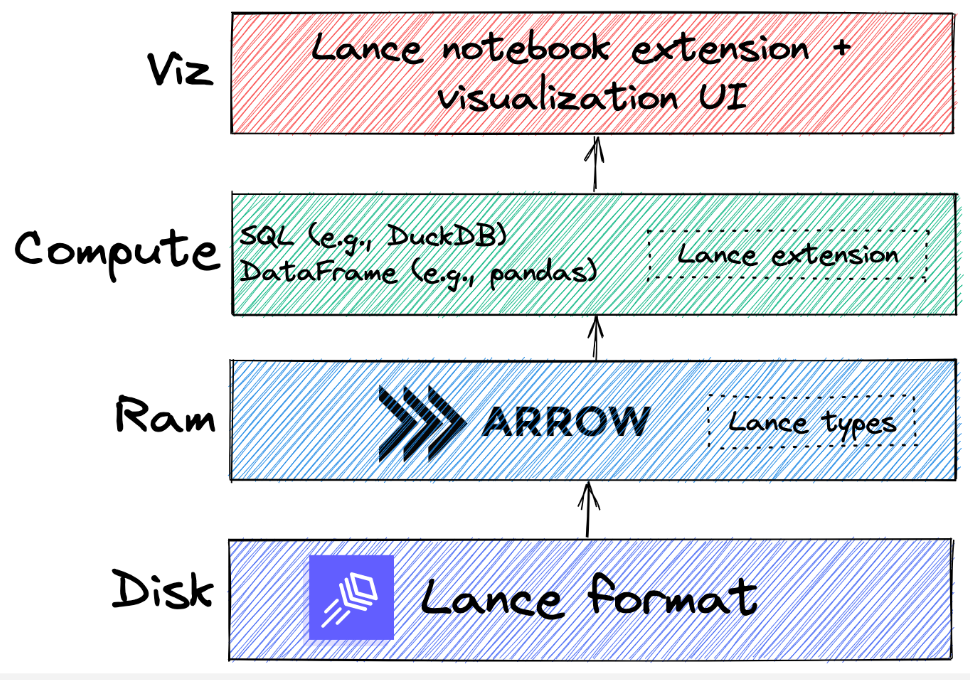

## Roadmap

- Support for deletes and cell-level updates
- Lazy evaluation columns
- Tags and provenance metadata